In [1]:
import cv2
import numpy as np
import zipfile
import os
import glob

# === Step 1: Extract ZIP ===
zip_path = "/content/calibimg.zip"  # Your uploaded zip file
extract_path = "/content/calibration_images"  # Absolute path recommended in Colab

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [2]:
# === Step 2: Calibration Parameters ===
CHECKERBOARD = (6, 8)  # (columns, rows) of INNER corners
square_size = (4.0, 2.0)  # mm — rectangular checkerboard: 4mm x 2mm cells

# Prepare object points for rectangular grid
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp[:, 0] *= square_size[0]  # scale X
objp[:, 1] *= square_size[1]  # scale Y

objpoints = []  # 3D real world points
imgpoints = []  # 2D image points
image_shape = None


In [ ]:
# === Step 3: Read and process images ===
images = glob.glob(os.path.join(extract_path, "calibimg", "*.jpg"))

print(f"Found {len(images)} images")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

    if ret:
        objpoints.append(objp)
        # Optional: Refine corner locations for better accuracy
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners_subpix = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners_subpix)
        image_shape = gray.shape[::-1]

Found 22 images


In [ ]:
# === Step 4: Camera Calibration ===
if image_shape is None:
    raise ValueError("No valid checkerboard corners found in any image.")

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, image_shape, None, None)

print("Camera Matrix:\n", mtx)
print("Distortion Coefficients:\n", dist)


Camera Matrix:
 [[1.36126776e+03 0.00000000e+00 9.77451650e+02]
 [0.00000000e+00 1.36697821e+03 5.77677112e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [[ 1.62196474e-03  3.12735086e-01 -3.24785370e-03 -2.13498350e-05
  -7.94939192e-01]]


debug code

In [ ]:
from google.colab.patches import cv2_imshow  # For Colab only

found_count = 0  # Counter for images with detected corners

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

    print(f"Processing {fname} - Checkerboard found: {ret}")

    if ret:
        found_count += 1
        objpoints.append(objp)
        imgpoints.append(corners)
        image_shape = gray.shape[::-1]

        # Draw and show corners
        img_vis = cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
        cv2_imshow(img_vis)
    else:
        cv2_imshow(img)
        print("Corners not found — check orientation or pattern.")

print(f"\nTotal images with detected checkerboard corners: {found_count} out of {len(images)}")


checking diameter

Reference line

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# === Step 5: Load Frame from Video ===
video_path = "/content/WhatsApp Video 2025-05-08 at 8.24.56 PM.mp4"
cap = cv2.VideoCapture(video_path)
success, frame = cap.read()
cap.release()

if not success:
    raise ValueError("Could not read frame from video")

In [ ]:
# === Step 6: Undistort Frame ===
undistorted = cv2.undistort(frame, mtx, dist, None, mtx)

# === Step 7: Enhance Image to Detect Pencil Line ===
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
high_pass = cv2.subtract(gray, blurred)

thresh = cv2.adaptiveThreshold(high_pass, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

Reference line length: 506.08 pixels ≈ 100 mm
Pixel-to-mm scale: 0.1976 mm/pixel


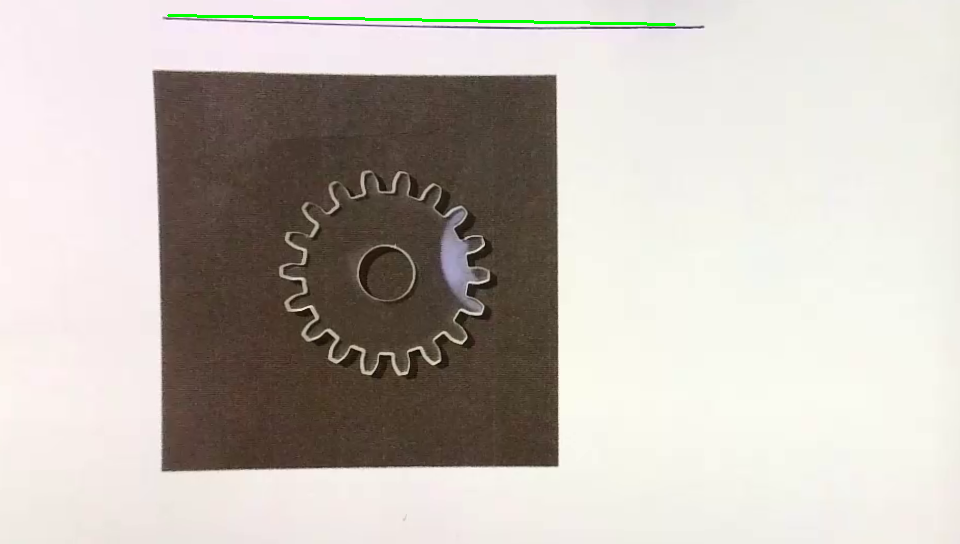

In [ ]:
# === Step 8: Hough Line Detection to Find 10 cm Reference ===
lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, threshold=50,
                        minLineLength=50, maxLineGap=10)

if lines is None:
    raise ValueError("Reference line not detected — try improving contrast or lighting.")

# === Step 9: Use Longest Line as Reference ===
longest_line = max(lines, key=lambda l: np.linalg.norm([l[0][2] - l[0][0], l[0][3] - l[0][1]]))
x1, y1, x2, y2 = longest_line[0]
pixel_length = np.linalg.norm([x2 - x1, y2 - y1])
scale = 100.0 / pixel_length  # mm/pixel

# Draw the reference line
cv2.line(undistorted, (x1, y1), (x2, y2), (0, 255, 0), 2)

print(f"Reference line length: {pixel_length:.2f} pixels ≈ 100 mm")
print(f"Pixel-to-mm scale: {scale:.4f} mm/pixel")

# Show result
cv2_imshow(undistorted)


Detected Gear Diameter: 168.00 pixels ≈ 33.20 mm


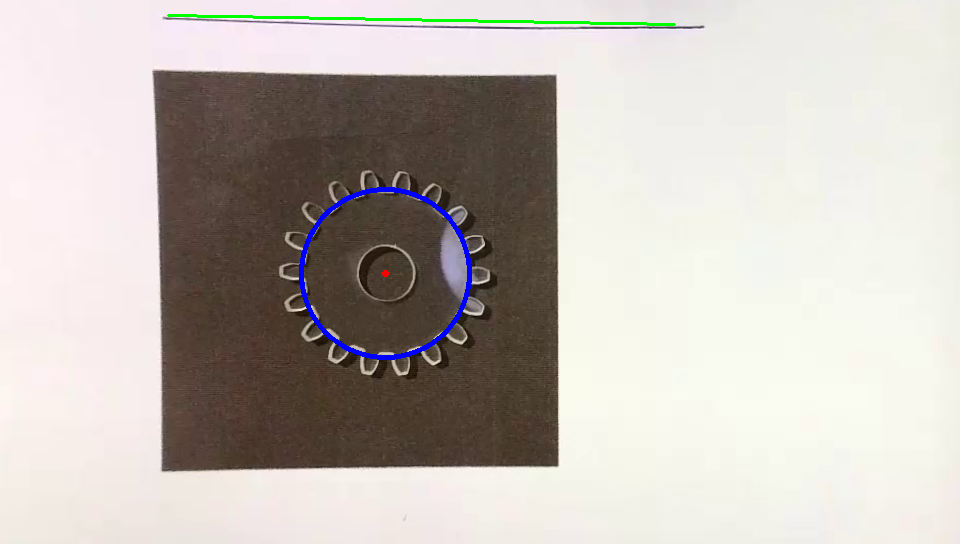

In [ ]:
# === Step 10: Detect the Gear Circle ===
# We'll use Hough Circle Transform assuming the gear is roughly circular
gray_undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.medianBlur(gray_undistorted, 5)

circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=100,
    param1=100,
    param2=30,
    minRadius=30,
    maxRadius=0  # 0 means no upper limit
)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :1]:  # take only the largest or first circle
        # Draw the detected gear
        cv2.circle(undistorted, (x, y), r, (255, 0, 0), 3)
        cv2.circle(undistorted, (x, y), 2, (0, 0, 255), 3)  # center

        # Calculate diameter
        diameter_pixels = 2 * r
        diameter_mm = diameter_pixels * scale
        print(f"Detected Gear Diameter: {diameter_pixels:.2f} pixels ≈ {diameter_mm:.2f} mm")
else:
    print("No gear circle detected — adjust lighting or detection parameters.")

# Show output
cv2_imshow(undistorted)


In [ ]:
# === Step 10: Detect the Gear Circle ===
# We'll use Hough Circle Transform assuming the gear is roughly circular
gray_undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.medianBlur(gray_undistorted, 5)

circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=100,
    param1=100,
    param2=30,
    minRadius=30,
    maxRadius=0  # 0 means no upper limit
)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :1]:  # take only the largest or first circle
        # Draw the detected gear
        cv2.circle(undistorted, (x, y), r, (255, 0, 0), 3)
        cv2.circle(undistorted, (x, y), 2, (0, 0, 255), 3)  # center

        # Calculate diameter
        diameter_pixels = 2 * r
        diameter_mm = diameter_pixels * scale
        print(f"Detected Gear Diameter: {diameter_pixels:.2f} pixels ≈ {diameter_mm:.2f} mm")
else:
    print("No gear circle detected — adjust lighting or detection parameters.")

# Show output
cv2_imshow(undistorted)
